In [1]:
import numpy as np
import random
import math
import heapq
import multiprocess as mp
import talib as ta
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from datetime import datetime,date
import time
from island_ga import IslandGGA 
from chromosome import Chromosome 
from data_preprocessing import Data
import itertools
import yfinance as yf
import datetime

[*********************100%***********************]  1 of 1 completed


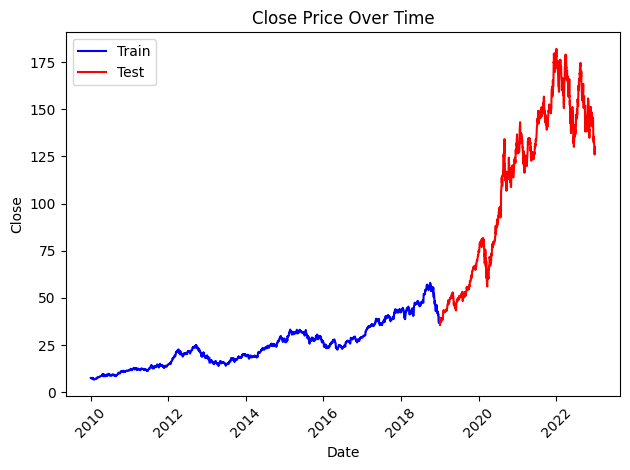

In [7]:
#AAPL
start_date = datetime.datetime(2010, 1, 1)
end_date = datetime.datetime(2022, 12, 31)
period ="train"
data = Data('AAPL',start_date,end_date,period,2019)
data.data_preprocess()

In [4]:
data.data_period = "train"
print("Train period:")
data.comparison_metrics()
data.buy_and_hold()
print("\n")
data.data_period = "test"
print("Test period:")
data.comparison_metrics()
data.buy_and_hold()

Train period:
Return: 2.718073887518733
Portfolio MDD: 1.5264969009628402
Portfolio Std Dev: 0.06411499538936224
Buy and Hold Strategy Profit: 4.75.
Buy and Hold Strategy MDD   : -0.07.


Test period:
Return: 1.6445314828908741
Portfolio MDD: 0.7658672247066628
Portfolio Std Dev: 0.1012646648014138
Buy and Hold Strategy Profit: 2.12.
Buy and Hold Strategy MDD   : -0.04.


In [14]:
data.data_period = "train"
print("Train period:")
data.comparison_metrics()
data.buy_and_hold()
print("\n")
data.data_period = "test"
print("Test period:")
data.comparison_metrics()
data.buy_and_hold()

Train period:
Return: 2.718073887518733
Portfolio MDD: 1.5264969009628402
Portfolio Std Dev: 0.06411499538936224
Buy and Hold Strategy Profit: 4.75.
Buy and Hold Strategy MDD   : -0.07.


Test period:
Return: 1.6445314828908741
Portfolio MDD: 0.7658672247066628
Portfolio Std Dev: 0.1012646648014138
Buy and Hold Strategy Profit: 2.12.
Buy and Hold Strategy MDD   : -0.04.


In [16]:
ga = IslandGGA(data=data.train_data,num_islands=10,pSize=150,strategies=data.top_strategy_names,evolve_strategy="ring")
ga.evolve()

Running ring
Generation 1: Best fitness = 0.9016925555416099 Average Fitness = 0.6305678426723192
Generation 2: Best fitness = 1.0751144247014395 Average Fitness = 0.6905242077813966
Generation 3: Best fitness = 1.19070012261377 Average Fitness = 0.7350464785202545
Generation 4: Best fitness = 1.19070012261377 Average Fitness = 0.7533449656979648
Generation 5: Best fitness = 1.5760200159528257 Average Fitness = 0.8026145048279556
Generation 6: Best fitness = 1.6893868770301383 Average Fitness = 0.8500979319393224
Generation 7: Best fitness = 1.6967185794497677 Average Fitness = 0.8738553089735284
Generation 8: Best fitness = 1.780278235363935 Average Fitness = 0.9004954598243569
Generation 9: Best fitness = 1.780278235363935 Average Fitness = 0.9188022074101049
Generation 10: Best fitness = 1.834361353663074 Average Fitness = 0.936317303184237
Island 0 Migration -Left island 19 -Right island 1
Island 1 Migration -Left island 0 -Right island 2
Island 2 Migration -Left island 1 -Right is

In [21]:
ga.globalBest.mdd

0.2172801538951618

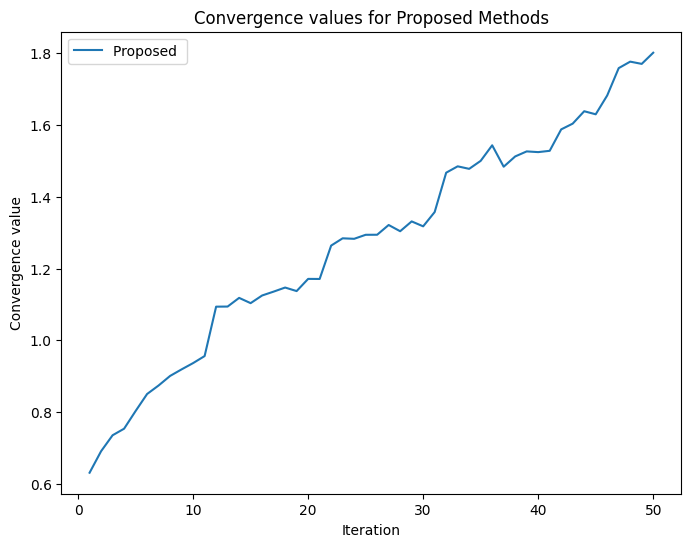

In [19]:
# Plot the convergence values for each evolutionary strategy
plt.figure(figsize=(8, 6))

plt.plot(np.arange(1, 51), ga.convergence_values, label='Proposed ')
plt.xlabel('Iteration')
plt.ylabel('Convergence value')
plt.title('Convergence values for Proposed Methods')
plt.legend()
plt.show()

In [ ]:


# Monthly returns for each strategy
monthly_returns = data.strategy_performance()


# Determine the grid dimensions
num_strategies = len(monthly_returns.columns)
grid_rows = int(num_strategies / 2)  # Number of rows in the grid
grid_cols = 2  # Number of columns in the grid

# Adjust the figure size based on the number of subplots
fig_width = 12
fig_height = 4 * grid_rows

# Create the subplots with the specified grid dimensions and figure size
fig, axes = plt.subplots(grid_rows, grid_cols, figsize=(fig_width, fig_height))

# Flatten the axes array if necessary
if grid_rows > 1:
    axes = axes.flatten()

# Iterate over each strategy and plot its cumulative profits
for idx, (strategy, returns) in enumerate(monthly_returns.iteritems()):
    cumulative_profits = np.cumprod(1 + returns)-1  # Calculate cumulative profits
    ax = axes[idx] if grid_rows > 1 else axes  # Select the correct subplot
    ax.plot(cumulative_profits)
    ax.set_xlabel('Month')
    ax.set_ylabel('Cumulative Profit')
    ax.set_title(f'Cumulative Profits for {strategy}')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()




In [ ]:
asset_prices = data.train_data.copy()
# Set the 'Date' column as the index of the DataFrame if it's not already
asset_prices.set_index('Date', inplace=True)

# Resample the asset prices to monthly frequency and select the first and last values of each month
monthly_prices = asset_prices.resample('M').agg({'close': ['first', 'last']})

# Calculate the monthly returns as the percentage change in price
monthly_returns = monthly_prices['close', 'last'].pct_change()

# Calculate the cumulative returns
cumulative_returns = (1 + monthly_returns).cumprod()

# Calculate the profit as the difference between the final cumulative return and 1 (initial investment)
profit = cumulative_returns.iloc[-1]-1

print("Profit for the Buy-and-Hold Strategy:")



In [ ]:

def max_drawdown(returns):
  """
  Calculates the maximum drawdown from monthly returns.

  Args:
    returns: A pandas DataFrame of monthly returns.

  Returns:
    The maximum drawdown.
  """

  # Calculate the cumulative returns.
  cumulative_returns = (1 + returns).cumprod()

  # Find the minimum value of the cumulative returns.
  min_return = cumulative_returns.min()

  # Calculate the maximum drawdown.
  max_drawdown = (1 - min_return) 

  return max_drawdown

if __name__ == "__main__":
  # Load the monthly returns data.

  asset_prices = data.train_data.copy()
  # Set the 'Date' column as the index of the DataFrame if it's not already
  asset_prices.set_index('Date', inplace=True)

  # Resample the asset prices to monthly frequency and select the first and last values of each month
  monthly_prices = asset_prices.resample('M').agg({'close': ['first', 'last']})

  # Calculate the monthly returns as the percentage change in price
  monthly_returns = monthly_prices['close', 'last'].pct_change()

  # Calculate the maximum drawdown.

  # Calculate the cumulative returns
  cumulative_returns = (1 + monthly_returns).cumprod()
  # Calculate the profit as the difference between the final cumulative return and 1 (initial investment)
  profit = cumulative_returns.iloc[-1]-1

  # Find the minimum value of the cumulative returns.
  min_return = cumulative_returns.min()

  # Calculate the maximum drawdown.
  max_drawdown = (1 - min_return) 

  max_drawdown = max_drawdown(monthly_returns)

  # Print the maximum drawdown.
  print(f"Buy and Hold mdd is {max_drawdown:.2f}.")
  print(f"Profit for the Buy and Hold Strategy: {profit:.2f}.")

